In [279]:
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from functools import reduce
import matplotlib.patches as patches
import matplotlib.backends.backend_pdf
from matplotlib import gridspec


gbenchJsonProcessMain /Users/ivankobzarev/myforks/pytorch/android/agpu/bench_results/data/bench_report.out


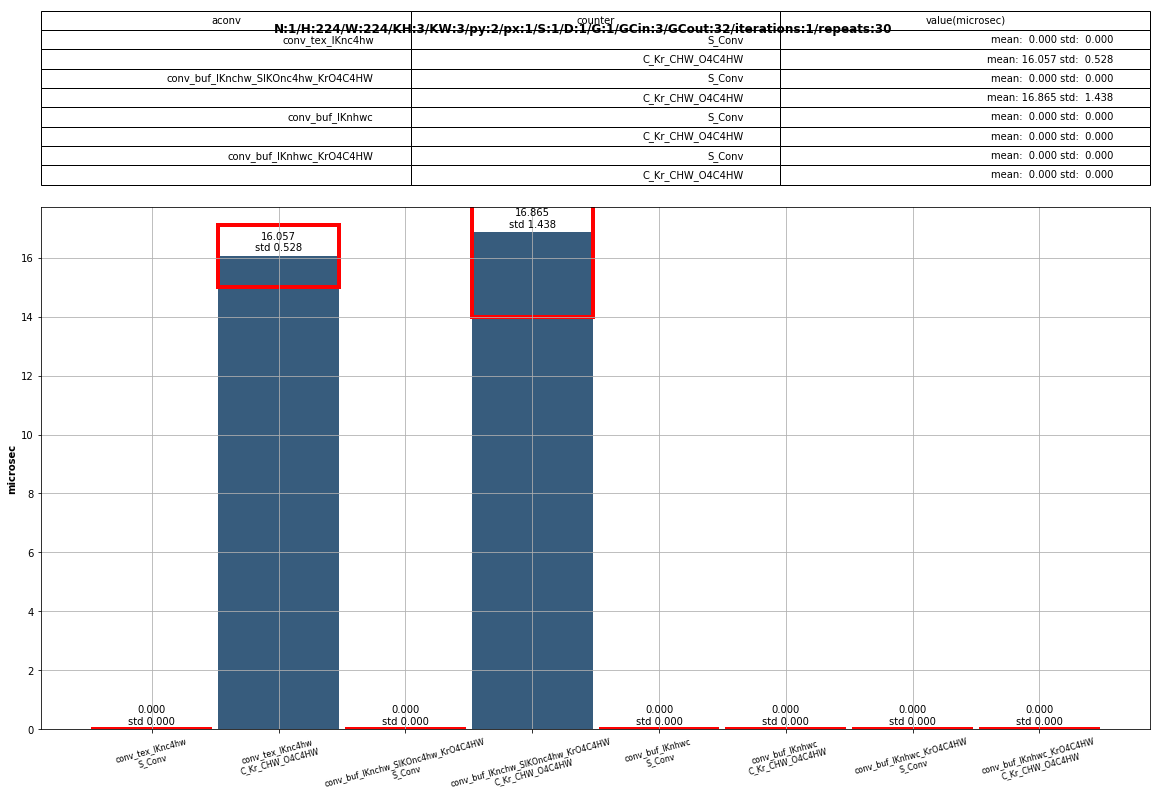

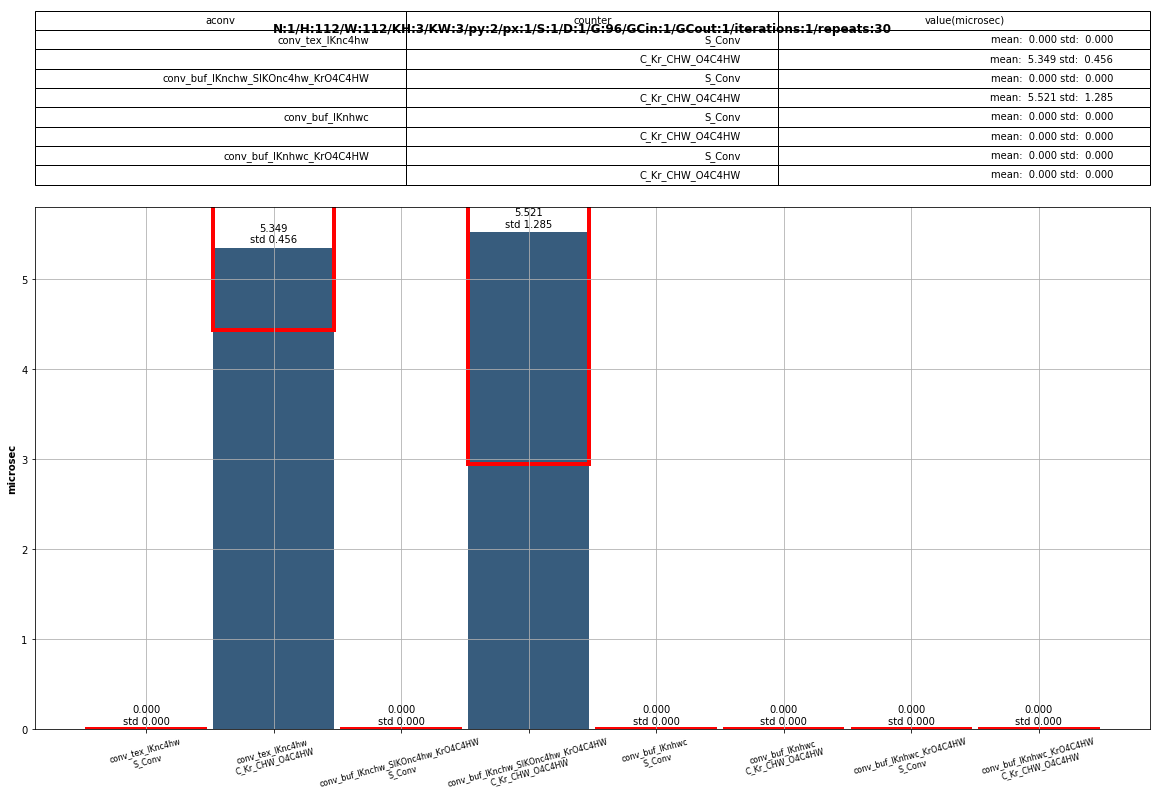

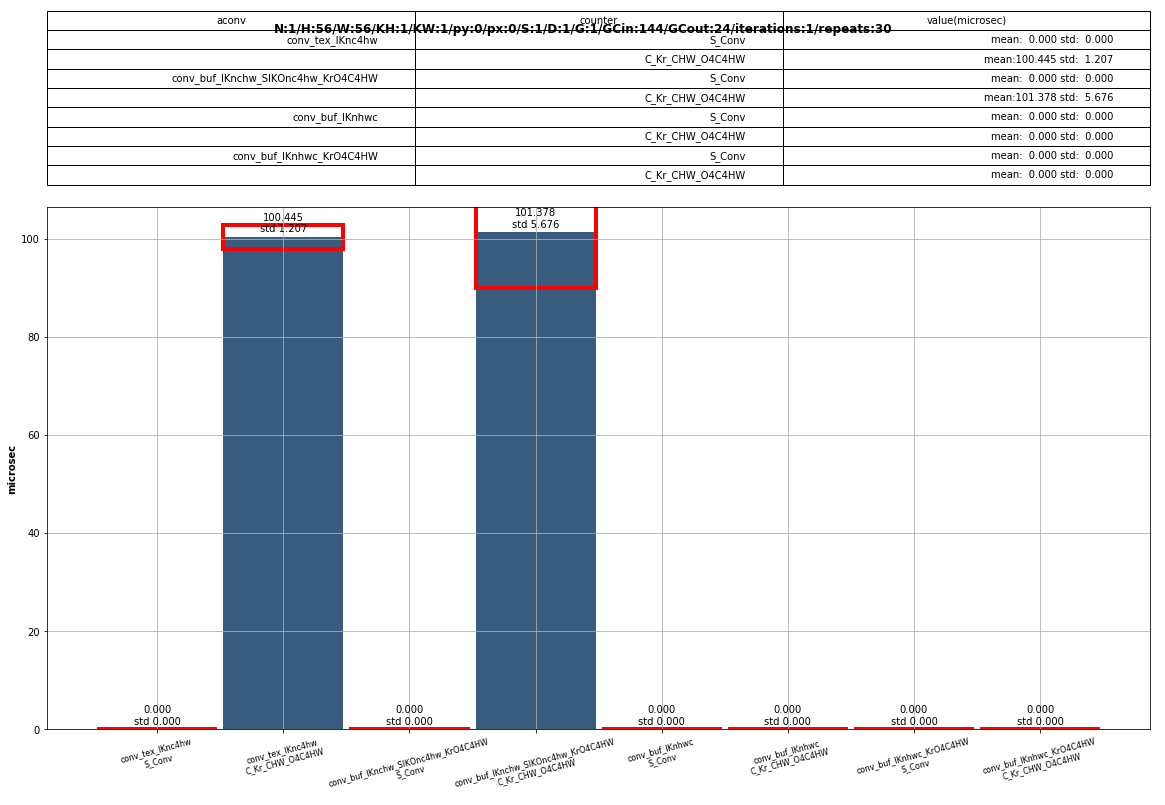

In [288]:

class PAConv:
    countersToShowDict = {
        "conv_buf_IKnchw_SIKOnc4hw_KrO4C4HW":["S_Conv", "C_Kr_CHW_O4C4HW"],
        "conv_buf_IKnchw_SIKOnc4hw_KrO4C4HW": ["S_Conv", "C_Kr_CHW_O4C4HW"],
        "conv_buf_IKnchw_SIKOnc4hw_KrO4HWC": ["S_Conv", "C_Kr_CHW_O4C4HW"],
        "conv_buf_IKnchw_SIKnc4hw_SOnchw": ["S_Conv", "C_Kr_CHW_O4C4HW"],
        "conv_buf_IKnchw_SKnc4hw_KrO4C4HW": ["S_Conv", "C_Kr_CHW_O4C4HW"],
        "conv_buf_IKnchw_SKnc4hw_KrO4C4HW_1": ["S_Conv", "C_Kr_CHW_O4C4HW"],
        "conv_buf_IKnhwc": ["S_Conv", "C_Kr_CHW_O4C4HW"],
        "conv_buf_IKnhwc_KrO4C4HW": ["S_Conv", "C_Kr_CHW_O4C4HW"],
        "conv_buf_IKnhwc_KrO4HWC": ["S_Conv", "C_Kr_CHW_O4C4HW"],
        "conv_buf_Inhwc_Knchw": ["S_Conv", "C_Kr_CHW_O4C4HW"],
        "conv_tex_IKnc4hw": ["S_Conv", "C_Kr_CHW_O4C4HW"],
    }        
            
    def getCountersToShow(aconvName):
        counters = PAConv.countersToShowDict[aconvName]
        if counters is None:
            raise Exception(f"Unknown AConv:{aconvName}")
        return counters
    
    def __init__(self, name, agg, json):
        self.name = name
        self.agg = agg
        self.jsonTrimmed = {}
        for k, v in json.items():            
            self.jsonTrimmed[k.strip()] = v
            
    def getCounter(self, counterName):
        return self.jsonTrimmed[counterName]

    def getCountersToShow(self):
        counters = PAConv.countersToShowDict[self.name]
        if counters is None:
            raise Exception(f"Unknown AConv:{self.name}")
        return counters
    
    def getCountersToShowDict(self):
        d = {}
        cs = self.getCountersToShow()
        for c in cs:
            d[c] = self.jsonTrimmed[c]
        return d

    def __repr__(self):
        s = ""
        cs = self.getCountersToShow()
        for c in cs:
            s += " {}:{}".format(c, self.jsonTrimmed[c])
        return "\n.PAConv(name:'{}'\n  agg:'{}' counters:{})".format(self.name, self.agg, s)


class PBenchmark:
    def __init__(self, name):
        self.name = name
        self.aconvsAggs = {}
    
    def addAconvAgg(self, aconvName, agg, aconv):
        if aconvName not in self.aconvsAggs:
            self.aconvsAggs[aconvName] = {}
        self.aconvsAggs[aconvName][agg] = aconv
        
    def __repr__(self):
        return "\n\nPBenchmark(\n  name:{}\n  aconvAggs:{})\n".format(self.name, self.aconvs)
    
def showBench(bench):
    valueColumn = f"value({TIME_UNIT_LABEL})"
    columnNames = ['aconv', 'counter', valueColumn]
    df = pd.DataFrame(columns = columnNames, dtype=np.float64)
    
    for aconvName in bench.aconvsAggs.keys():
        aconvAggs = bench.aconvsAggs[aconvName]
        aconvMean = aconvAggs['mean']
        aconvStd = aconvAggs['std']
        ci = 0
        for cname, cvalue in aconvMean.getCountersToShowDict().items():
            row = {}
            row['aconv'] = aconvName if ci == 0 else ""
            row['counter'] = cname
            
            meanv = TIME_UNIT_MULTIPLIER * cvalue
            stdv = TIME_UNIT_MULTIPLIER * aconvStd.getCounter(cname)       
                
            row[valueColumn] = ("mean:{:7.3f} std:{:7.3f}".format(meanv, stdv))
            df.loc[len(df)] = row
            ci = ci + 1
            
    FIG_W = 16
    FIG_H = 11
        
    ### Table
    fig = plt.figure(figsize=(FIG_W, FIG_H))
    fig.suptitle(bench.name, fontweight='bold', fontsize=12)
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3]) 
    
    axTable = plt.subplot(gs[0])
    axChart = plt.subplot(gs[1])

    
    axTable.axis('off')
    axTable.table(cellText=df.values, colLabels=df.columns, bbox=[0,0,1,1])
    
    ### Chart
    GAP_RATIO = 0.05
    
    barX = []
    barMeanValues = []
    barStdValues = []    
    groupLabels = []
    barLabels = []
    barColors = []
    
    nAconvs = len(bench.aconvsAggs)
    
    maxCounters = -1
    for aconvName, aggsDict in bench.aconvsAggs.items():
        for aconv in aggsDict.values():
            countersToShowLen = len(aconv.getCountersToShow())
            if (countersToShowLen > maxCounters):
                maxCounters = countersToShowLen

    nGroups = len(bench.aconvsAggs)
    nW = nGroups * (maxCounters + 1)
    barWidth = FIG_W / (nW + (nW - 1) * GAP_RATIO)
    gapWidth = barWidth * GAP_RATIO
    X = np.arange(nW) * (barWidth + gapWidth)
    
    gi = 0                
    for aconvName, aconvAggs in bench.aconvsAggs.items():
        aconvMean = aconvAggs['mean']
        aconvStd = aconvAggs['std']

        groupLabels.append(aconvName)
        bi = 0
        
        for cName, cMeanValue in aconvMean.getCountersToShowDict().items():
            xidx = maxCounters*gi + bi
            barX.append(X[xidx])            
            
            barMeanValues.append(TIME_UNIT_MULTIPLIER * cMeanValue)
            barStdValues.append(TIME_UNIT_MULTIPLIER * aconvStd.getCounter(cName))
            
            barLabels.append(f"{aconvName}\n{cName}")
            barColors.append(getColorByCounterName(cName))            
            bi = bi + 1
        gi = gi + 1
        
    rects = plt.bar(barX, barMeanValues, width=barWidth, color=barColors)
    i = 0
    stdBarWidth = barWidth
    for rect in rects:
        x = rect.get_x()
        w = rect.get_width()
        h = rect.get_height()
        std = barStdValues[i]
        stdK = 2
        
        axChart.annotate('{:.3f}\nstd {:.3f}'.format(h, std),
                    xy=(x + w/2, h),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
        
        pr = patches.Rectangle(
            (x + (w-stdBarWidth)/2, h - stdK*std),
            stdBarWidth, 2*stdK*std, 
            linewidth=4,
            edgecolor='r',
            facecolor='none')
        axChart.add_patch(pr)
        
        i = i + 1
    
    plt.xticks(rotation=15)
    plt.xticks(barX, barLabels)
    
    for tick in axChart.xaxis.get_major_ticks():
        tick.label.set_fontsize(8) 
        
    axChart.grid()
    axChart.set_ylabel(TIME_UNIT_LABEL, fontweight='bold')
    fig.tight_layout(pad=0.05)
    plt.show()
    pdf.savefig(fig)    
                                
#"name": "BM_conv_agpu/base/ACX:30/N:1/H:112/W:112/KH:3/KW:3/py:2/px:1/S:1/D:1/G:96/GCin:1/GCout:1/iterations:1/repeats:30/manual_time__p90",
#"run_name": "BM_conv_agpu/base/ACX:30/N:1/H:112/W:112/KH:3/KW:3/py:2/px:1/S:1/D:1/G:96/GCin:1/GCout:1/iterations:1/repeats:30/manual_time",

BENCH_NAME_RE = re.compile(r'.*ACX:(\d+)/(.*repeats:\d+)')

TIME_UNIT_MULTIPLIER = 1e6
TIME_UNIT_LABEL = "microsec"

CONV_BAR_COLOR = "#F67280"
KR_BAR_COLOR = "#375C7D"
DEF_BAR_COLOR = "#F8B195"

def getColorByCounterName(counterName):
    if (counterName == 'S_Conv'):
        return CONV_BAR_COLOR
    elif (counterName.find('C_Kr_') != -1):
        return KR_BAR_COLOR
    
    return DEF_BAR_COLOR


def acx_from_runName(runName):
    return int(BENCH_NAME_RE.match(runName).group(1))
        
def benchName_from_runName(runName):
    return BENCH_NAME_RE.match(runName).group(2)
        
def processJsonBench(jsonBench, acxToAConvNameDict, aggNamesDict, outPBenchmarks):
    aggNameRaw = jsonBench["aggregate_name"]
    if aggNameRaw not in aggNamesDict:
        return
    
    aggName = aggNamesDict[aggNameRaw]
    jsonRunName = jsonBench["run_name"]

    acx = acx_from_runName(jsonRunName)
    aconvName = acxToAConvNameDict[acx]
    benchName = benchName_from_runName(jsonRunName)

    pBenchmark = None
    if (benchName in outPBenchmarks):
        pBenchmark = outPBenchmarks[benchName]
    else:
        pBenchmark = PBenchmark(benchName)
        outPBenchmarks[benchName] = pBenchmark

    aconv = PAConv(aconvName, aggName, jsonBench)
    pBenchmark.addAconvAgg(aconvName, aggName, aconv)    
    
def parseAgpuGlslH(filepath):
    d = {}
    aconvPattern = re.compile(r'\s*(\S*)\s*=\s*(\d+)\s*')
    with open(filepath) as f:
        lines = f.read().split("\n")
        for l in lines:
            m = aconvPattern.match(l)
            if (m):
                aconvName = m.group(1)
                aconvCode = int(m.group(2))
                d[aconvCode] = aconvName
    return d
    
def benchJsonReportProcessMain(filepath, acxToAConvNameDict, aggNamesDict):
    pBenchmarks = {}
    
    print("gbenchJsonProcessMain {}".format(filepath))
    with open(filepath) as f:
        fileContent = f.read()
        jsonObject = json.loads(fileContent)
        for jsonBench in jsonObject["benchmarks"]:
            processJsonBench(jsonBench, acxToAConvNameDict, aggNamesDict, pBenchmarks)
    return pBenchmarks

# main
pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")

PATH_AGPU_GLSL_H = "/Users/ivankobzarev/myforks/pytorch/android/agpu/src/agpu_glsl.h"
acxToAConvNameDict = parseAgpuGlslH(PATH_AGPU_GLSL_H)

aggNamesDict = {
    "_mean_afterPreBurn": "mean",
    "_std_afterPreBurn": "std",
}

PATH_BENCH_REPORT_JSON = "/Users/ivankobzarev/myforks/pytorch/android/agpu/bench_results/data/bench_report.out"
benchmarks = benchJsonReportProcessMain(PATH_BENCH_REPORT_JSON, acxToAConvNameDict, aggNamesDict)

for benchname, bench in benchmarks.items():
    showBench(bench)
    
pdf.close()    
    